# Homework 7 Template

Rixin Li & G . Besla



In [1]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass2 import CenterOfMass

# import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [366]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename):
        ''' class to determine the acceleration M33 feels from M31 and integrate its
        current position and velocity forwards in time

            PARAMETERS:
            ----------
            outfile: 'str'
                snapshot file of galaxy with the integrated orbit
        '''

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### store the output file name
        self.filename = filename

        # hard-coding tolerance and VolDec for M33 for COM_P calc
        delta = 0.1
        VolDec_M31 = 2
        VolDec_M33 = 4
        
        ### get the current pos/vel of M33 
        
        # create an instance of the  CenterOfMass class for M33 for disk particle
        M33_COM = CenterOfMass('M33_000.txt', 2)

        # store the position VECTOR of the M33 COM
        self.M33_p = M33_COM.COM_P(delta, VolDec_M33)
        
        # store the velocity VECTOR of the M33 COM (.value to get rid of units)
        self.M33_v = M33_COM.COM_V(self.M33_p[0], self.M33_p[1], self.M33_p[2])
        
        ### get the current pos/vel of M31 
    
        # create an instance of the  CenterOfMass class for M31 
        M31_COM = CenterOfMass('M31_000.txt', 2)

        # store the position VECTOR of the M31 COM
        self.M31_p = M31_COM.COM_P(delta, VolDec_M31)
    
        # store the velocity VECTOR of the M31 COM (.value to get rid of units)
        self.M31_v = M31_COM.COM_V(self.M31_p[0], self.M31_p[1], self.M31_p[2])
        
        ### store the DIFFERENCE between the vectors posM33 - posM31

        # create two VECTORs self.r0 and self.v0 and have them be the relative position and velocity VECTORS of M33
        self.r0 = (self.M33_p - self.M31_p).value
        self.v0 = (self.M33_v - self.M31_v).value
        
        ### get the mass of each component in M31 
        # disk
        self.rdisk = 5  # kpc
        self.Mdisk = 1e12 * ComponentMass('M31_000.txt', 2)

        # bulge
        self.rbulge = 1  # kpc
        self.Mbulge = 1e12 * ComponentMass('M31_000.txt', 3)

        # Halo
        self.rhalo = 62  # in kpc from hw 5
        self.Mhalo = 1e12 * ComponentMass('M31_000.txt', 1)

        
    def HernquistAccel(self, M, r_a, r): 
        """ 
            calculates the Hernquist acceleration for the halo and bulge particles

            PARAMETERS:
            ----------
                M: 'float'
                    mass of the galaxy component in Msun
                r_a: 'float'
                    Hernquist profile scale length for the given component in kpc
                r: 'float'
                    position vector of the component in kpc

            OUTPUT:
            ------
                Hern: np.array
                    hernquist acceleration vector in kpc/Gyr^2
        """
        
        ### Store the magnitude of the position vector
        rmag = np.linalg.norm(r)
        
        ### *** Store the Acceleration
        # use -G*M/(rmag *(r_a + rmag)**2) * r --> where the last r is a VECTOR 
        
        G = self.G
        b = -G * M  # numerator
        c = (rmag * (r_a + rmag) ** 2)  # denominator

        Hern =  b/c * r
        
        return Hern
    
    
    def MiyamotoNagaiAccel(self, M, r_d, r):
        """ 
            calculates the Miyamoto-Nagai acceleration for the disk

            PARAMETERS:
            ----------
                M: 'float'
                    mass of the disk in Msun
                r_d: 'float'
                    disk radius in kpc
                r: 'float'
                    position vector of the disk in kpc

            OUTPUT:
            ------
                MN_acc: np.array
                    Miyamoto-Nagai acceleration vector in kpc/Gyr^2
        """
        
        # define each part of the MN equation
        G = self.G
        x, y, z = r
        r_d = self.rdisk
        z_d = self.rdisk/5.0
        Rmag = np.sqrt( x**2 + y**2 )
        B = r_d + np.sqrt( z**2 + z_d**2 )

        # the z component is different than in the x or y directions
        # deal with this by multiplying the whole thing by an extra array that accounts for the differences in the z direction:
        # multiply the whle thing by :   np.array([1,1,B/np.sqrt(r[2]**2 + z_d**2)])
        # the np.array allows for a different value for the z component of the acceleration
        b = -G * M * np.array([1.0, 1.0, B/np.sqrt(r[2]**2 + z_d**2)])  # numerator
        c = (Rmag**2 + B**2)**(3/2)  # denominator

        MN_acc = b/c * r
        
        return MN_acc
     
    
    def M31Accel(self, r): 
        """
            calculates the total acceleration of M31 at some position r

            PARAMETER:
            ---------
                r: 3D np.array 
                    relative position of galaxy component in kpc

            OUTPUT:
            ------
                M31_acc: np.array
                    total acceleration of M31
        """

        ### Call the previous functions for the halo, bulge and disk
        halo_acc = self.HernquistAccel(self.Mhalo, self.rhalo, r)
        bulge_acc = self.HernquistAccel(self.Mbulge, self.rbulge, r)
        disk_acc = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)

        # adding M31 acceleration components
        M31_acc = halo_acc + bulge_acc + disk_acc

        return M31_acc
      
    
    def LeapFrog(self, r, v, dt): 
        """
            function that advances the position and velocity of M33 at future timesteps

            PARAMETERS:
            ----------
                r: np.array
                    initial position vector of M33 relative to M31
                v: np.array
                    initial velocity of M33 relative to M31
                dt: 'float'
                    change in time for timestep in Gyr

            OUTPUTS:
            -------
                rnew: np.array
                    position vector at the next timestep
                vnew: np.array
                    velocity vector at the next timestep
        """
    
        # predict the position at the next half-timestep
        rhalf = r + v*(dt/2)
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        ahalf = self.M31Accel(rhalf)
        vnew = v + ahalf*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = rhalf + vnew*(dt/2)
        
        return rnew, vnew
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """ 
             function that integrates the orbit of M33 forward in time from t0 to tmax with timestep dt

             PARAMETERS:
             ----------
                 t0: 'float'
                     initial time in Gyr
                 dt: 'float'
                     change in time for timestep in Gyr
                 tmax: 'float'
                     final time in Gyr

             OUTPUT:
             ------
                 outfile: txt file
                     contains the orbit array with columns: [t,x,y,z,vx,vy,vz]
        """

        # initialize the time to the input starting time
        t = t0
        # initialize the position and velocity
        r_initial = self.r0
        v_initial = self.v0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt) + 2, 7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(r_initial), *tuple(v_initial)
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t <= tmax):  # as long as t has not exceeded the maximal time 
            
            # advance the time by one timestep, dt
            t += dt
            
            # use LeapFrog to find new pos and vel
            r, v = self.LeapFrog(r_initial, v_initial, dt)

            # store the new time in the first column of the ith row
            # orbit[i,0] = t

            orbit[i] = t, *tuple(r), *tuple(v)

            # store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # orbit[i,1:4] = r
            # store the new velocity vector into the columns with indexes 4,5,6 of the ith row of orbit
            # orbit[i,4:7] = v

            # updating pos and vel for the next iteration
            r_initial = r
            v_initial = v
            
            # update counter i, where i is keeping track of the number of rows
            i += 1
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f "*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        

In [368]:
# initialize intstance of M33AnalyticalOrbit class
M33orbit = M33AnalyticOrbit('M33_AnalyticOrbit.txt')

# integrate orbit and save data in txt file
M33orbit.OrbitIntegration(0,0.1,10)

Plotting the orbit of M33 (analysis):

In [370]:
# define output files for each galaxy from hw 6
MW = 'Orbit_MW.txt'
M31 = 'Orbit_M31.txt'
M33 = 'Orbit_M33.txt'

In [371]:
# reading in the data files for the orbits of each galaxy that were just created using np.genfromtxt
# headers:  t, x, y, z, vx, vy, vz
MW_data = np.genfromtxt('Orbit_MW.txt', dtype=None, comments='#')
M31_data = np.genfromtxt('Orbit_M31.txt', dtype=None, comments='#')
M33_data = np.genfromtxt('Orbit_M33.txt', dtype=None, comments='#')
M33_analytic_orbit = np.genfromtxt('M33_AnalyticOrbit.txt', comments='#')

In [372]:
# function to compute the magnitude of the difference between two vectors 
# using this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  
def VectorMagnitude(obj1, obj2):
    '''
    function computes the magnitude of the difference between two 3-dimensional vectors

    PARAMETERS:
    ----------
        obj1: '3-dimensional array of floats or astropy quantities'
            position/velocity vector of the first object
        obj2: '3-dimensional array of floats or astropy quantities'
            position/velocity vector of the second object

    RETURNS:
    -------
        mag: 'float or astropy quantity'
            magnitude of the difference between the two vectors
    '''

    # finding the distance between each vector for the x, y, and z direction
    x_diff = obj1[0] - obj2[0]
    y_diff = obj1[1] - obj2[1]
    z_diff = obj1[2] - obj2[2]

    # computing the magnitude of the differences
    mag = np.sqrt( (x_diff**2) + (y_diff**2) + (z_diff**2) )
    return mag


In [373]:
# assigning variables to analytic data
t_A = M33_analytic_orbit[:,0]
x_A = M33_analytic_orbit[:,1]
y_A = M33_analytic_orbit[:,2]
z_A = M33_analytic_orbit[:,3]
vx_A = M33_analytic_orbit[:,4]
vy_A = M33_analytic_orbit[:,5]
vz_A = M33_analytic_orbit[:,6]

r_A = np.sqrt(x_A**2 + y_A**2 + z_A**2)
v_A = np.sqrt(vx_A**2 + vy_A**2 + vz_A**2)

In [374]:
# need to determine the relative motion of M31 and M33
# assigning variables to data in txt files for M31 and M33

t_M31  = M31_data[:,0]
x_M31  = M31_data[:,1]
y_M31  = M31_data[:,2]
z_M31  = M31_data[:,3]
vx_M31 = M31_data[:,4]
vy_M31 = M31_data[:,5]
vz_M31 = M31_data[:,6]

t_M33  = M33_data[:,0]
x_M33  = M33_data[:,1]
y_M33  = M33_data[:,2]
z_M33  = M33_data[:,3]
vx_M33 = M33_data[:,4]
vy_M33 = M33_data[:,5]
vz_M33 = M33_data[:,6]

# calculating the relative distances in x, y, and z
x_rel = x_M33 - x_M31
y_rel = y_M33 - y_M31
z_rel = z_M33 - z_M31

# calculating the position vector for M31-M33
r_rel = np.sqrt(x_rel**2 + y_rel**2 + z_rel**2)

# calculating the relative velocities in x, y, and z
vx_rel = vx_M33 - vx_M31
vy_rel = vy_M33 - vy_M31
vz_rel = vz_M33 - vz_M31

# calculating the velocity vector for M31-M33
v_rel = np.sqrt(vx_rel**2 + vy_rel**2 + vz_rel**2)

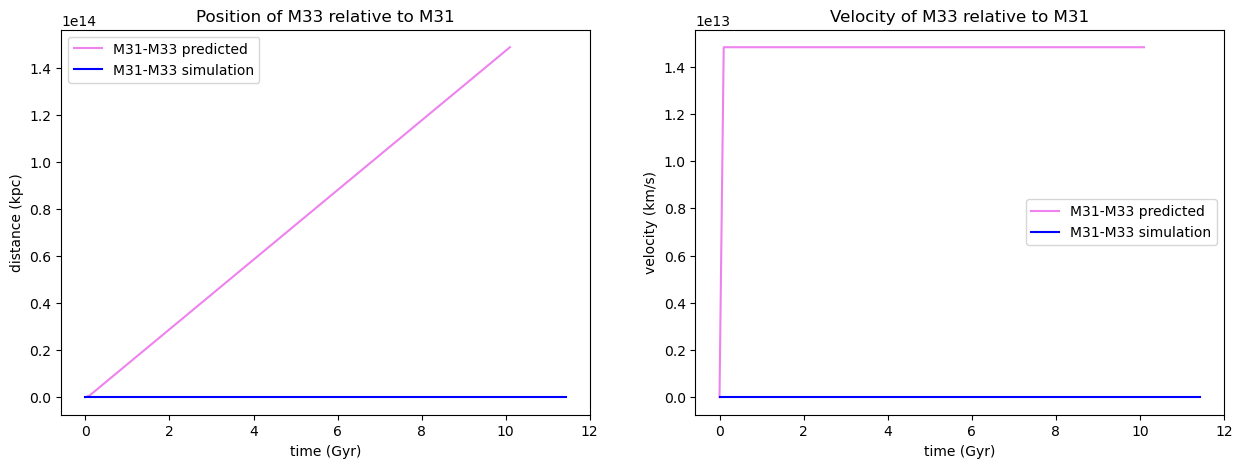

In [375]:
# using time from M31 orbit for plotting
time = t_M31

fig, ax = plt.subplots(1, 2, figsize=(15,5))

# position versus time plot
ax[0].set_title('Position of M33 relative to M31')
ax[0].set_xlabel('time (Gyr)')
ax[0].set_ylabel('distance (kpc)')
ax[0].plot(t_A, r_A, color='violet', label='M31-M33 predicted')
ax[0].plot(time, r_rel, color='b', label='M31-M33 simulation')
ax[0].legend()

# velocity versus time plot
ax[1].set_title('Velocity of M33 relative to M31')
ax[1].set_xlabel('time (Gyr)')
ax[1].set_ylabel('velocity (km/s)')
ax[1].plot(t_A, v_A, color='violet', label='M31-M33 predicted')
ax[1].plot(time, v_rel, color='b', label='M31-M33 simulation')
ax[1].legend()

plt.show()